# Network theory, Plot analysis
Introduction - This notebook uses the social network of actor appearances in a movie ('Love Actually') to analyze the characters and plot of the movie. Broad themes that are explored in the analysis are: Structural significance of specific scenes to the movie's social network, Different methods to identify the linchpin or central character in the movie, Community detection technique and what it tells about the plot and a Passive Bechdel test. The idea is inspired by a FiveThirtyEight article and Stanford Literary Lab studies (https://litlab.stanford.edu/LiteraryLabPamphlet2.pdf). The data and full story can be accessed here https://github.com/fivethirtyeight/data/tree/master/love-actually

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Description of data
There are two data files:
1. love_actually_appearances.csv - A table of the central actors in "Love Actually" and which scenes they appear in
2. love_actually_adjacencies.csv - The adjacency matrix of which actors appear in the same scene together
Note: According to the article the data has been manually curated by watching the movie multiple times. 
Brief description of the plot and characters is presented in the appendix.

### Reading adjacency matrix data

In [2]:
df = pd.read_csv('love_actually_adjacencies.csv', header=0, sep=',', index_col=0).fillna(0)
print (df.head())

                 bill_nighy  keira_knightley  andrew_lincoln  hugh_grant  \
actors                                                                     
bill_nighy                9              0.0             0.0         0.0   
keira_knightley           2              7.0             0.0         0.0   
andrew_lincoln            2              7.0             8.0         0.0   
hugh_grant                2              1.0             1.0        13.0   
colin_firth               1              2.0             2.0         1.0   

                 colin_firth  alan_rickman  heike_makatsch  laura_linney  \
actors                                                                     
bill_nighy               0.0           0.0             0.0           0.0   
keira_knightley          0.0           0.0             0.0           0.0   
andrew_lincoln           0.0           0.0             0.0           0.0   
hugh_grant               0.0           0.0             0.0           0.0   
colin_firth

In [3]:
#Function to build a weighted, undirected graph from the adjacency matrix
def add_adjacencies_to_weighted_graph(df):
    M = nx.Graph()
    for i in df.index:
        #print (i)
        M.add_node(i)
        for j in df.columns:
            if df.ix[i,j] != 0.0:
                #print (i,j, df.ix[i,j])
                M.add_edge(i, j, weight=df.ix[i,j])
    return M

In [4]:
G = add_adjacencies_to_weighted_graph(df)

In [5]:
# differentiating edges by their weight to plot the network
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > 8]
emedium=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >= 4 and d['weight'] <= 8]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] < 4]

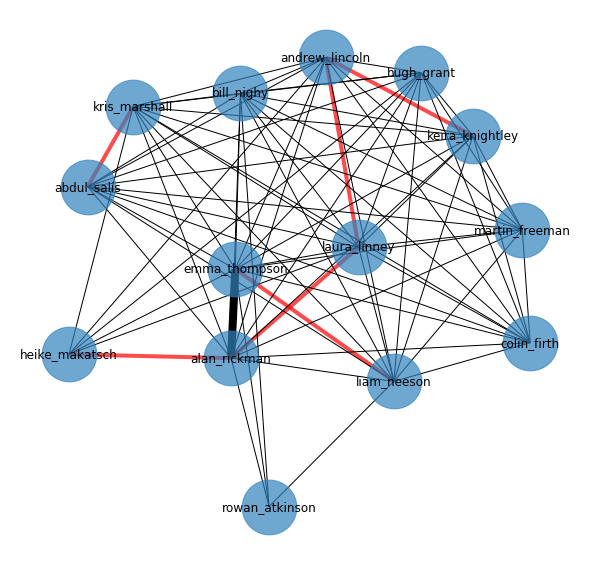

In [6]:
# Plotting the network
plt.figure(num=None, figsize=(10, 10))
plt.axis('off')
fig = plt.figure(1)

pos=nx.spring_layout(G,k=0.7,iterations=20, scale=5)
# nodes
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color="#3182bd", alpha=0.7)
# edges
nx.draw_networkx_edges(G, pos, width=8, edgelist=elarge, edge_color='black')
nx.draw_networkx_edges(G, pos, width=4, edgelist=emedium, edge_color='red', alpha=0.7)
nx.draw_networkx_edges(G, pos, width=1, edgelist=esmall, color='grey')
# labels
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')

plt.show()

In [7]:
# The network looks tightly connected. Let's see if it's a connected graph and get the clustering coefficient.
nx.is_connected(G)
nx.average_clustering(G)

0.9292374292374294

### Testing structural significance of specific scenes

It's surprising that a movie with so many characters has a social network that's completely connected i.e. there is a path from every character in the movie to another based on their appearances. The clustering coefficient if very high  as well. What does this tell us about the movie's plot? 
On examining the scene appearances data, there is only one scene towards the epilogue (title: At the airport again) where all characters appear on the screen together. What is the structural significance of the epiloggue scene to the movie's social network? Let's first read the data and see the scene descriptions and character appearances. 

In [8]:
df_appearances = pd.read_csv('love_actually_appearances.csv', sep=',', header=0, index_col=0).fillna('False')
df_appearances = df_appearances[pd.notnull(df_appearances.index)] #removing the extra empty rows

print (df_appearances.head(), df_appearances.shape)

                       bill_nighy keira_knightley andrew_lincoln hugh_grant  \
scenes                                                                        
Airport                     False           False          False       True   
Music recording              True           False          False      False   
Firth leaving for work      False           False          False      False   
Liam's wife was TAKEN       False           False          False      False   
Food delivery ugh           False           False          False      False   

                       colin_firth alan_rickman heike_makatsch laura_linney  \
scenes                                                                        
Airport                      False        False          False        False   
Music recording              False        False          False        False   
Firth leaving for work        True        False          False        False   
Liam's wife was TAKEN        False        False    

In [9]:
#Let's see who are the characters appearing in the climax: At the airport again scene
print (df_appearances.loc['At the airport again'])

bill_nighy          True
keira_knightley     True
andrew_lincoln      True
hugh_grant          True
colin_firth         True
alan_rickman        True
heike_makatsch     False
laura_linney        True
emma_thompson       True
liam_neeson         True
kris_marshall       True
abdul_salis         True
martin_freeman      True
rowan_atkinson     False
Name: At the airport again, dtype: object


Almost all of the actors (12/14) appear in this scene. Let's see what happens to the network by removing edges corresponding to this particular scene. 

In [10]:
actors_in_epilogue_scene = []
#Function to delete epilogue scene information from the network by reducing the edge weight by 1 between all actors appearing in the epilogue scene. If the weight becomes 0 (the actors appeared together only in the epilogue scene), delete the edge completely. 
for actor in df_appearances.columns.values:
    if df_appearances.loc['At the airport again'][actor] == True:
        actors_in_epilogue_scene.append(actor)
for (u,v,d) in G.edges(data=True):
        if u in actors_in_epilogue_scene and v in actors_in_epilogue_scene:
            d['weight'] -= 1
            if d['weight'] < 1:
                #print (u,v,d)
                G.remove_edge(u,v)

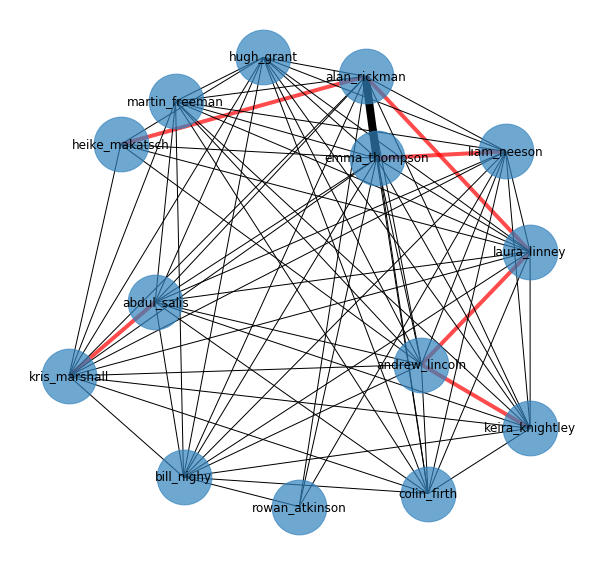

In [11]:
# Plot the modified network

plt.figure(num=None, figsize=(10, 10))
plt.axis('off')
fig = plt.figure(1)

pos=nx.spring_layout(G,k=0.7,iterations=20, scale=5)
# nodes
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color="#3182bd", alpha=0.7)
# edges
nx.draw_networkx_edges(G, pos, width=8, edgelist=elarge, edge_color='black')
nx.draw_networkx_edges(G, pos, width=4, edgelist=emedium, edge_color='red', alpha=0.7)
nx.draw_networkx_edges(G, pos, width=1, edgelist=esmall, color='grey')
# labels
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')

plt.show()

In [12]:
# Does not look very different. Let's look at the clustering coefficient 
print (nx.is_connected(G))
nx.average_clustering(G)

True


0.5804988662131519

The network is still connected, even after removing information from the climax scene. Would that be typical of other movie networks? Surprisingly, the average clustering coefficient of the network dropped from 0.93 to 0.58. Therefore, the epilogue scene had some structural significance to the movie's social network.

### Identifying the linchpin character
How do we determine who is the most "important" character in the network. One way to define "importance" is using centrality measures. The betweenness centrality is a measure of how many shortest paths pass through a particular node. The more shortest paths that pass through the node, the more central the vertex is to the network. Let's look at different centrality measures of the nodes.

In [13]:
# Function to rank the nodes based on their betweenness centrality
def most_important(G):
    ranking = nx.betweenness_centrality(G).items()
    #print (ranking)
    r = [x[1] for x in ranking]
    m = sum(r)/len(r) # mean centrality
    t = m*2 # threshold,  keep only the nodes with 2 times the mean
    Gt = G.copy()
    for k, v in ranking:
        if v < t:
            Gt.remove_node(k)
    return Gt

Gt = most_important(G) 

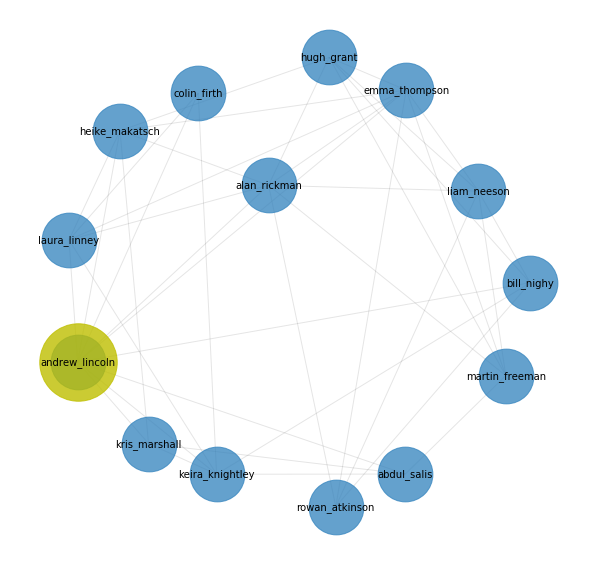

In [15]:
#Plotting the network, highlighting the most central character
plt.figure(num=None, figsize=(10, 10))
plt.axis('off')
fig = plt.figure(1)

# create the layout
pos=nx.spring_layout(G,k=0.7,iterations=20, scale=5)

# draw the nodes and the edges 
nx.draw_networkx_nodes(G,pos,node_color='#3182bd',node_size=3000, alpha=0.75)
nx.draw_networkx_edges(G,pos,alpha=0.1)

# draw the most important nodes with a different style
nx.draw_networkx_nodes(Gt,pos,node_color='y',alpha=0.8,node_size=6000)
# draw labels
#nx.draw_networkx_labels(Gt,pos,font_size=12,font_color='black')
nx.draw_networkx_labels(G,pos,font_size=10,font_color='black')
plt.show()

Andrew Lincoln appears to the most central character in the network, the linchpin of it all. In a movie like this with 9 different subplots running, it is interesting how one character appears to be the most central. Andrew Lincoln has a very minor role in the movie; he is part of a love triangle in one of the nine subplots of the movie. But, what makes him the central character is that he is connected to other actors in the movie in very different contexts. He is friends with Heike Makatsch and Chiwetel Ejiofor. He is in love with Keira Knightley, Chiwetel Ejiofor's wife in the movie. He also runs an art gallery that hosted a Christmas party that Alan Rickman, Emma Thompson attend.

Although his role is minor, because of the different connections above, Andrew Lincoln becomes the node that most shortest paths in the network pass through. Is centrality the only way to measure importance of a character in the movie? 

In [16]:
# Function to count the number of appearances of a character with rest of the cast
def get_cast_spoken_to(df, actor):
    count = 0
    for i in df.index:
        if i == actor:
            for j in df.columns:
                if j != actor:
                    count += df.ix[i,j]
    for j in df.columns:
        if j == actor:
            for i in df.index:
                if i != actor:
                    count += df.ix[i,j]
    return count

In [17]:
# Measuring importance of a character viz. screen time and the percent of cast that the character speaks to in the movie. For screen time, using the appearances dataset with screen and character information. 
actors = df_appearances.columns.values
screen_time = {}
cast_spoken_to = {}
for actor in actors:
    screen_time[actor] = (df_appearances[actor] == True).sum()
    cast_spoken_to[actor] =  get_cast_spoken_to(df, actor)

In [18]:
# Ranking the actors based on screen time and cast spoken to
for actor in actors:
    print (actor, screen_time[actor]+cast_spoken_to[actor])

bill_nighy 26.0
keira_knightley 30.0
andrew_lincoln 35.0
hugh_grant 32.0
colin_firth 27.0
alan_rickman 48.0
heike_makatsch 25.0
laura_linney 35.0
emma_thompson 44.0
liam_neeson 34.0
kris_marshall 25.0
abdul_salis 26.0
martin_freeman 24.0
rowan_atkinson 6.0


Other characters like Alan Rickman, Emma Thompson and Laura Linney also appear to be important to the movie's network when importance is operationalized via screen time and cast spoken to. These three characters, mainly Laura Linney become important by their connections in the plot to other characters. She’s there at Knightley’s wedding, asking the  best man (Andrew Lincoln) if he needs a shoulder to cry on. She’s there at the Christmas party, reassuring Thompson, who is watching her husband (Alan Rickman) fall for another woman (Heike Makatsch). And she’s there for her mentally ill brother (Michael Fitzgerald).

### Community detection and what it tells us about the plot

In [19]:
! pip install python-louvain

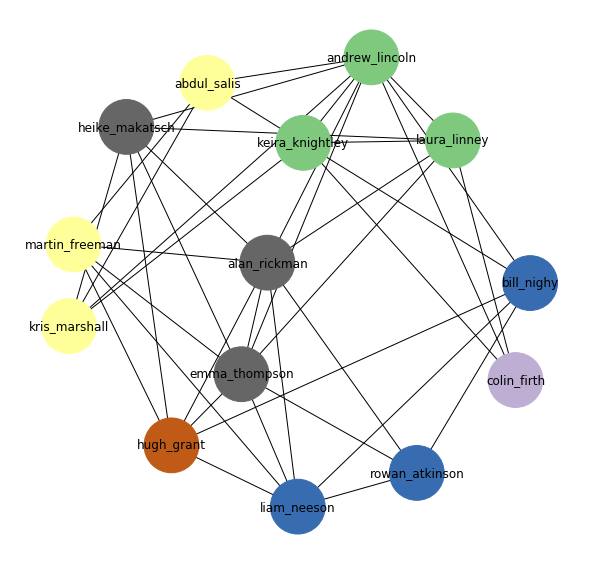

In [20]:
import community

# best_partition computes the partition of the graph nodes which maximises the modularity using the Louvain heuristices
part = community.best_partition(G)
values = [part.get(node) for node in G.nodes()]

plt.figure(num=None, figsize=(10, 10))
plt.axis('off')

# create the layout
pos=nx.spring_layout(G,k=0.7,iterations=20, scale=5)

#Drawing the network, with colors specifying community the node belongs to
nx.draw(G,pos, cmap = plt.get_cmap('Accent'), node_color = values, node_size=3000, with_labels=True)


How well do the communities identified fit into the plot of the movie?
1. Alan Rickman, Emma Thompson and Heike Makatsch : Alan Rickman and Emma Thompson are a married couple in the movie. Makatsch is Rickman's new secretary and as the storyline proceeds he begins to get attracted to her. 
2. Kris Marshall, Abdul Salis and Martin Freeman : Kris Marshall and Abdul Salis are friends in the movie. After unsuccesfully wooing English women in the movie, Kris Marshall informs his friend Abdul Salis that he plans to go to America, where his English accent will be an asset. Abdul Salis is a production assistant and Martin Freeman who is a professional body double in films, meets him on set.
3. Keira Knightley, Andrew Lincoln and Laura Linney : Andrew Lincoln is in love with Keira Knightley and devasted during her wedding, Laura Linney consoles him. Other than this storyline, Laura Linney is a weak connection to this community. 
4. Liam Nelson, Rowan Atkinson and Bill Nighy are minor side roles in the movie and their cluster does not make sense. 
5. Finally, Hugh Grant, who plays the prime minister of UK in the movie and is the most popular cast on the movie but appears alone in the clustering. 

## Appendix 
Note - Includes additional supplementary analysis

## Description of movie - 
"Love Actually", the 2003 movie is the story of nine interconnected relationships in the weeks ahead of Christmas in the United Kingdom. It has a plotline for every moment in a relationship, from first crush to the grave, and the story covers all the holiday season staples: the Christmas party, the school pageant, the holiday songs. The screenplay delves into different aspects of love as shown through the separate stories involving a wide variety of individuals, many of whom are shown to be interlinked as their tales progress. A quick reference of characters can be found in the Wiki page: https://en.wikipedia.org/wiki/Love_Actually

## Additional analysis - Passive Bechdel test 
The Bechdel test comes from studies on gender portrayal in popular fiction and asks whether a work of fiction features at least two women who talk to each other about something other than a man. The requirement that the two women must be named is sometimes added. The current dataset does not provide information on specific speech acts between characters and only gives information on co-appearance in a scene. Therefore running a passive bechdel test by looking for co-appearances of female characters in the movie.

In [21]:
actors
M_actors = ['bill_nighy', 'andrew_lincoln', 'hugh_grant', 'colin_firth', 'alan_rickman', 'liam_neeson', 'kris_marshall', 'abdul_salis', 'martin_freeman', 'rowan_atkinson']
F_actors = ['keira_knightley', 'heike_makatsch', 'laura_linney', 'emma_thompson' ]

In [22]:
for (u,v,d) in G.edges(data=True):
    if u in F_actors and v in F_actors and u!=v:
        print (u,v,d)

laura_linney keira_knightley {'weight': 2.0}
laura_linney emma_thompson {'weight': 1.0}
laura_linney heike_makatsch {'weight': 3.0}
emma_thompson heike_makatsch {'weight': 3.0}


"Love Actually" seems to have passed the passive bechdel test. With so many lead female characters in the movie, this was expected. Searching online, the movie also passed the actual bechdel test i.e. there were actual speech acts between two female characters in the movie. 

## Additional analysis - Degree distribution of the network

In [23]:
#Plot degree distribution of the network
def plot_degree_distribution(wiki):
    degs = {}
    for n in wiki.nodes():
        deg = wiki.degree(n)
        if deg not in degs :
            degs [deg] = 0
        degs [deg] += 1
    items = sorted(degs.items())
    items = sorted(degs.items())
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    ax.plot ([k for (k, v ) in items] ,[v for (k, v) in items ])
    ax.set_xscale ('log')
    ax.set_yscale ('log')

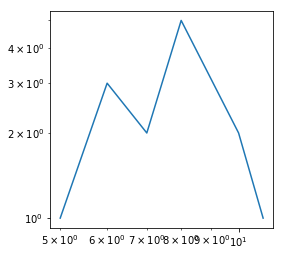

In [24]:
plot_degree_distribution(G)

The degree distribution does not look like some of the previous networks that we looked at in class: OpenSecrets, Twitter etc. The network's degree distribution does not seem to be following a power law. All nodes(characters) have an average degree in terms of their appearances with other actors. 